# Cohort Project 2021: Trapped Ions

This notebook provides a solution for the "Trapped Ions" project (week 1) for the CDL cohort project of 2021. See the original Github repositiory [here](https://github.com/CDL-Quantum/CohortProject_2021).  This requires to installation of cirq.



In [20]:
import cirq
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from cirq.contrib.svg import SVGCircuit
import sys

%matplotlib inline

#Set Figure Sizes
plt.rcParams["figure.figsize"] = (20,10)

# Functions

In the following we define two custom gates for the single-bit rotation and the two-qubit interaction.

In [21]:
class r_gate(cirq.Gate):
    """Rotation gate."""
    def __init__(self, theta, phi):
        super(r_gate, self)
        self.theta = theta
        self.phi = phi
        

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        return np.array([
            [np.cos(self.theta / 2), -1j * np.exp(-1j * self.phi) * np.sin(self.theta / 2)],
            [-1j * np.exp(1j * self.phi) * np.sin(self.theta / 2), -np.cos(self.theta / 2)]
        ])

    def _circuit_diagram_info_(self, args):
        return f"R({self.theta},{self.phi})"


class m_gate(cirq.TwoQubitGate):
    """M gate"""
    def __init__(self, Theta):
        super(m_gate, self)
        self.Theta = Theta

    def _unitary_(self):
        return np.array([
            [1.0 * np.cos(self.Theta), 0.0, 0.0, -1j * np.sin(self.Theta)],
            [0.0, 1.0 * np.cos(self.Theta), -1j * np.sin(self.Theta), 0.0],
            [0.0, -1j * np.sin(self.Theta), 1.0 * np.cos(self.Theta), 0.0],
            [-1j * np.sin(self.Theta), 0.0, 0.0, 1.0 * np.cos(self.Theta)]])

    def _circuit_diagram_info_(self, args):
        return f"M_rot({self.Theta})", f"M_rot({self.Theta})"


The following functions are instead needed to sample the random circuit, calculate the probability and the linear cross-entropy benchmarking fidelity.

In [22]:
def run(N, depth, num_samples, noise=False, del_Theta=0):
    qreg = [cirq.LineQubit(i) for i in range(N)]
    circuit = cirq.Circuit()

    for i in range(depth):
        for j in range(N):
            # random single-bit gate
            theta = 2 * np.pi * np.random.rand()
            phi = 2 * np.pi * np.random.rand()
            R_gate = r_gate(theta=theta, phi=phi)
            circuit.append(R_gate(qreg[j]))

        # Alternate start qubit for pairs.
        idx_first = i % 2
        
        for j in np.arange(idx_first, N - 1, 2):
            Theta = 2 * np.pi * np.random.rand()
            M_gate = m_gate(Theta=2 * np.pi * np.random.rand())
            circuit.append(M_gate(qreg[j], qreg[j + 1]))

    circuit.append([cirq.measure(qreg[i]) for i in range(N)])
    
    # add noise gate
    if noise ==True:
        circuit.insert(np.random.randint(0, len(circuit)),
                       cirq.X(qreg[np.random.randint(0, N)]))
    # print('Circuit:')
    # print(circuit)

    sim = cirq.Simulator()
    result = sim.run(circuit, repetitions=num_samples)

    return qreg, circuit, result


def Prob_X(result, bit_string, num_samples):
    num_states = pow(2,N)
    agg = result.data.groupby(result.data.columns.tolist(),as_index=False).size()
    agg['probability'] = agg['size']/num_samples
    agg['bit_string'] = ''
    for row in range(agg.shape[0]):
        for col in range(agg.shape[1]-3):
            agg.iloc[row,N+2] += str(agg.iloc[row,col])
    agg_row = agg[agg['bit_string'] == bit_string]
    if len(agg_row['probability'].values) == 0:
        return 0
    return agg_row['probability'].values[0]


#Cross Entropy
def XEB(P_dist,N,sample_size):
    return 2*sum(P_dist)-1

# Task 1

## A Single Circuit

D:\Programs\Anaconda\lib\site-packages\cirq\vis\state_histogram.py:103: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


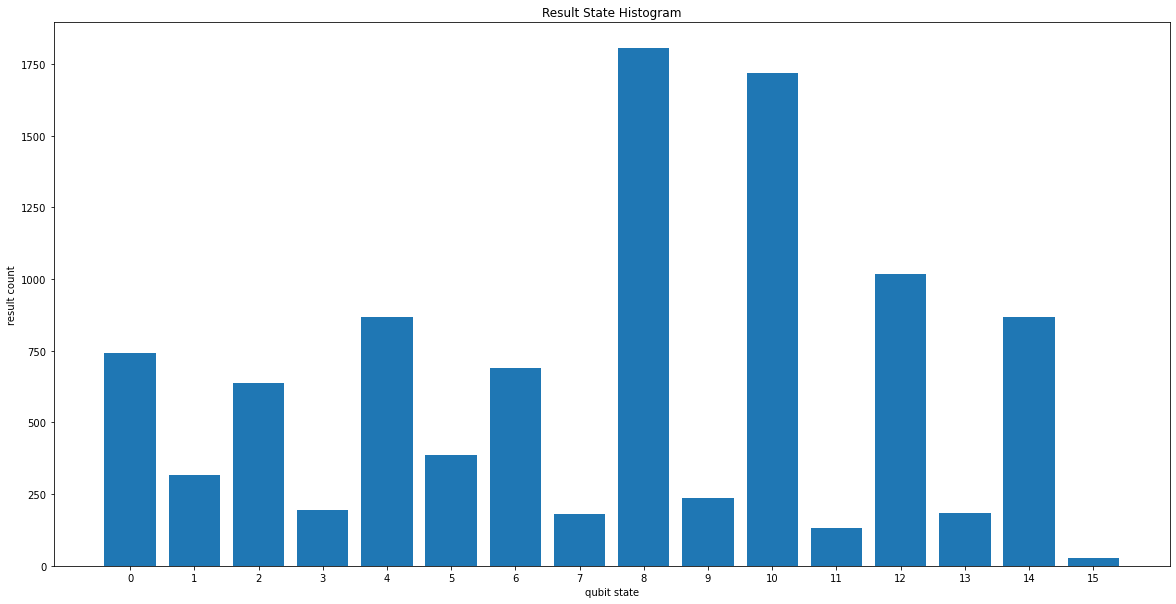

In [23]:
# basic run of the random circuit
np.random.seed(1234)
N = 4
depth = 3
num_samples=10000

qreg, circuit, result = run(N, depth, num_samples)
_ = cirq.vis.plot_state_histogram(result)

## Outputing probability 

In [24]:
bit_string = '1001'
Prob_X(result, bit_string, num_samples)

0.0236

## Interference Visualization

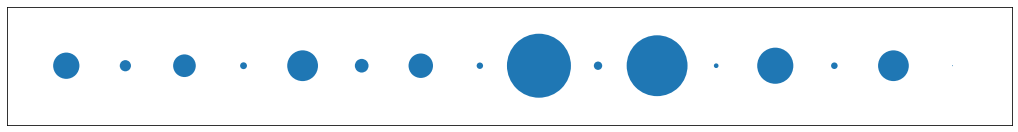

In [27]:
def interference_vis(num_states,result):
    fig, ax = plt.subplots(figsize=(18,4))
    plt.tick_params(left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)
    ax.set_aspect("equal")

    circle_list = []
    circle = []

    circle_x = np.arange(num_states)+1
   
    for i in range(num_states):
        bit_string = bin(i)[2:]
        bit_string =(4-len(bit_string))*'0'+bit_string
        c = plt.Circle((circle_x[i],0), (3)*Prob_X(result, bit_string, num_samples))
        ax.add_artist(c)
   
    plt.xlim([0,num_states+1])
    plt.ylim([-1,1])
    plt.show()
interference_vis(16,result) 

# Task 2

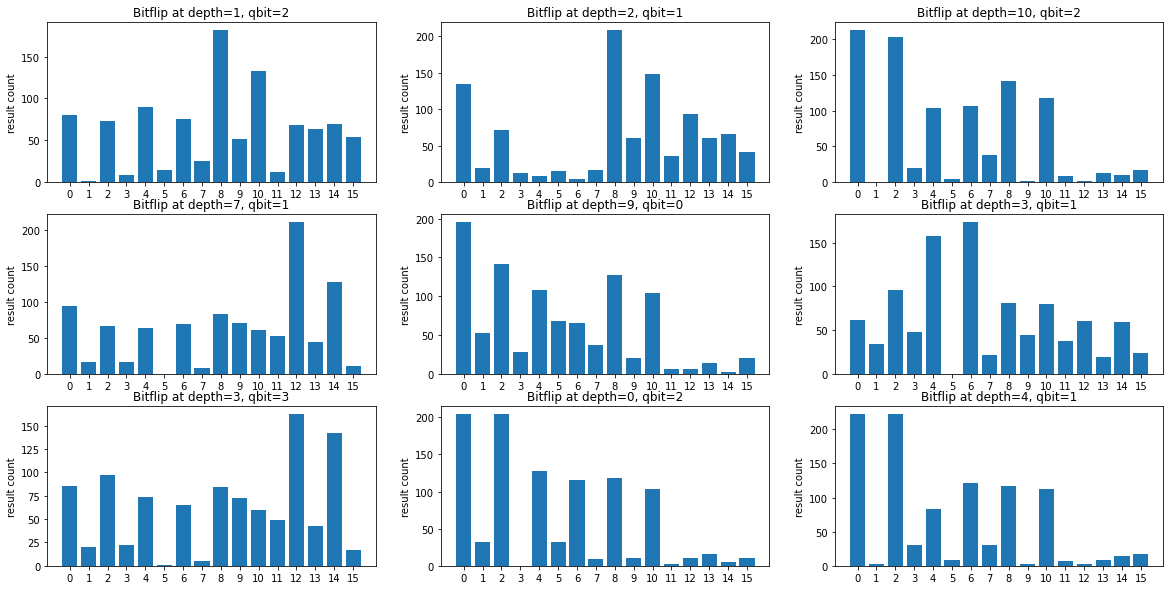

In [6]:
# Add sigma_x randomly and run of the random circuit
n_sims = 9
N = 4
depth = 3
n_pl = int(np.ceil(np.sqrt(n_sims)))
fig, ax = plt.subplots(n_pl, n_pl)

for x in range(n_sims):
    circuit_w_bitflip = circuit
    i = x % n_pl
    j = int(np.floor(x / n_pl))

    # randomly insert the bitflip
    depth_X = np.random.randint(0, len(circuit))
    qbit_X = np.random.randint(0, N)
    circuit_w_bitflip.insert(depth_X, cirq.X(qreg[qbit_X]))

    sim = cirq.Simulator()
    result = sim.run(circuit_w_bitflip, repetitions=1000)

    # result = run(N, depth, sigma_x=True)
    _ = cirq.vis.plot_state_histogram(result, ax[i,j], 
                                      title=f"Bitflip at depth={depth_X}, qbit={qbit_X}", xlabel = '')



# Task 3

We consider here several depths and plot the empirical cumulative distribution against the Porter-Thomas distribution (exponential). The larger is the depth, the closer the empirical distribution is to the exponential.

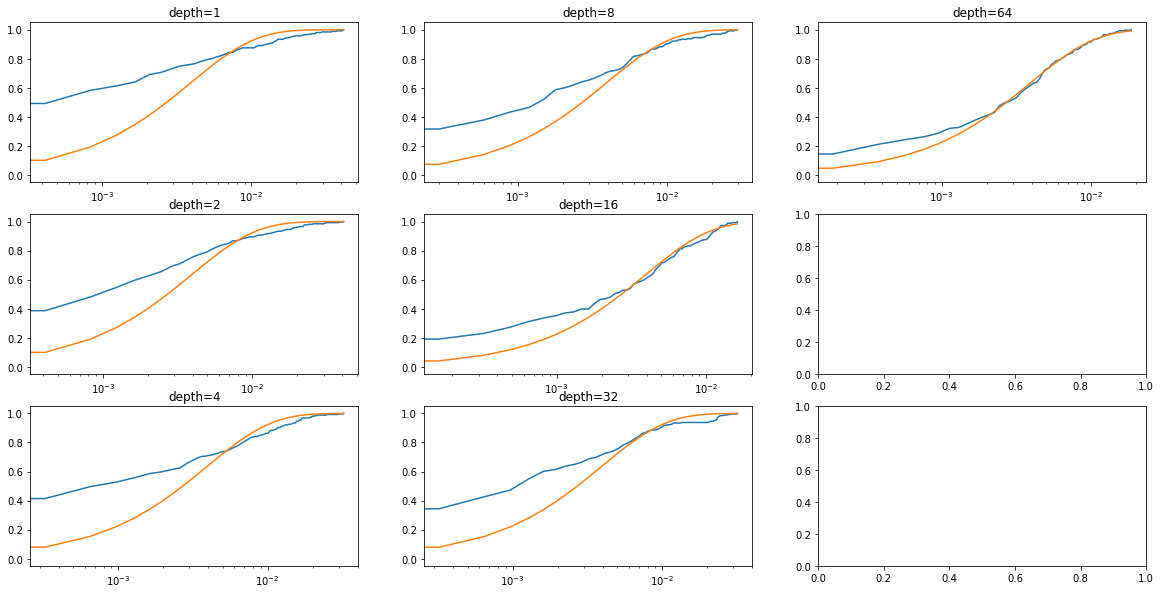

In [7]:
    # Test different depths
    N = 8
    max_depth_exp = 7
    depths = [2**n for n in range(max_depth_exp)]
    n_sims = len(depths)
    n_pl = int(np.ceil(np.sqrt(n_sims)))
    fig2, ax2 = plt.subplots(n_pl, n_pl)

    for x in range(n_sims):
        np.random.seed(1234)
        i = x % n_pl
        j = int(np.floor(x / n_pl))

        qreg, circuit, result = run(N, depths[x], num_samples)
        # _ = cirq.vis.plot_state_histogram(result, ax2[i, j], title=f"depth={depths[x]}")

        df = result.data
        for c in df.columns:
            df['b' + c] = df[c] * 2 ** int(c)
            df.drop(c, axis=1)

        df['sum_all'] = df[df.columns[-N:]].sum(axis=1)

        all_nums = range(2 ** N)
        hist = [df[df['sum_all'] == i].shape[0] for i in range(2 ** N)]
        probs = [df[df['sum_all'] == i].shape[0] / df.shape[0] for i in range(2 ** N)]

        values, base = np.histogram(probs, bins=100)

        cumulative = np.cumsum(values)/2**N

        # plot the cumulative function
        ax2[i,j].semilogx(base[:-1], cumulative)
        ax2[i,j].plot(base[:-1], [(1 - np.exp(-pow(2, N) * p)) for p in base[:-1]], label='Porter-Thomas')
        ax2[i,j].set_title(f"depth={depths[x]}")


# Task 4



In [10]:
# Run several times varying Big Theta and plot F_XEB vs del_Theta

N = 2
depth = 100
num_samples = 100

XEBs =[]
del_Thetas=[]

#Loop over sets of del_Theta
del_Theta = 0
for i in range(100):
    del_Theta+=3.14/100
    del_Thetas.append(del_Theta)
    #Loop over all bitstring combinations
    P_dist = []
    for bit_string in ['00','01','10','11']:
        qreg, circuit, result = run(N, depth,num_samples,del_Theta)
        P_dist.append( Prob_X(result,bit_string,num_samples))
    XEBs.append(XEB(P_dist,N,num_samples))


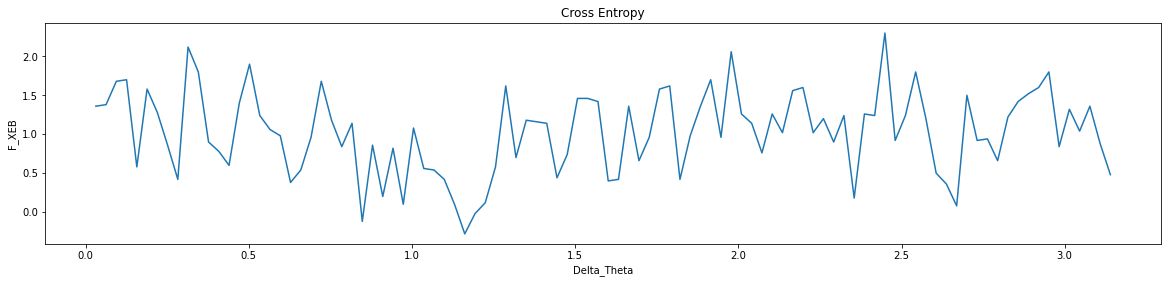

In [11]:
#Plot  F_XEB vs Delta_Theta
#print((XEBs),(del_Thetas))
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(211)
ax1.set_ylabel('F_XEB')
ax1.set_title('Cross Entropy')
ax1.set_xlabel('Delta_Theta')
plt.plot(del_Thetas,XEBs,label ='Cross-Entropy')
